In [1]:
import os
import polars as pl
from RIG import RuleInstanceGenerator
import pandas as pd

csv_path = "data/data_yuda.csv"
df = pl.read_csv(csv_path)

rig = RuleInstanceGenerator(rag_difference=1)



# folder_path = "data/rule_types/"
# for file_name in os.listdir(folder_path):
#     if file_name.endswith(".json"):
#         print(rig.new_rule_type(folder_path + file_name))

llama_new_context_with_model: n_ctx_per_seq (1024) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn

In [2]:

def clean_text(text):
    """Remove all non-alphanumeric characters and convert to lowercase."""
    return ''.join(char.lower() for char in text if char.isalnum())

def evaluate_accuracy():
    rag_api = rig.get_instance.classifier.rag_api
    rows = []
    correct_predictions = 0

    # Iterate through the DataFrame rows
    for row in df.iter_rows(named=True):
        # Extract the free_text, actual type_name, and expected classification
        free_text = row['free_text']
        actual_type_name = row['rule_types_names']
        id_free_text = row['id']

        # Predict the type name using the RAG API
        predicted_type_name = str(rag_api.get_closest_type_name(free_text)[0][0])

        # Clean strings for comparison
        actual_type_name_cleaned = clean_text(actual_type_name)
        predicted_type_name_cleaned = clean_text(predicted_type_name)

        # Debugging: Print the cleaned strings
        # print(f"Actual (cleaned): {actual_type_name_cleaned}")
        # print(f"Predicted (cleaned): {predicted_type_name_cleaned}")

        # Calculate the score (1 for correct, 0 for incorrect)
        score = 1 if predicted_type_name_cleaned == actual_type_name_cleaned else 0
        correct_predictions += score

        # Append the results to the rows
        rows.append({
            "id": id_free_text,
            "score": score,
            "predicted": predicted_type_name_cleaned,
            "actual": actual_type_name_cleaned,
            "free_text": free_text,
        })

    # Convert rows to a DataFrame
    results_df = pl.DataFrame(rows)

    # Calculate the final score
    accuracy = correct_predictions / len(df)

    return results_df, accuracy

# Run the evaluation
results_df, final_score = evaluate_accuracy()

# Print the final accuracy score
print(f"Accuracy Score: {final_score:.2%}")

# Print rows where the prediction was incorrect
errors = results_df.filter(pl.col("score") == 0).to_dicts()
# print("Errors:", errors)

# Optional: Save errors to a CSV
results_df.filter(pl.col("score") == 0).write_csv("output/classification_errors.csv")

print("results_df['actual'].unique():\n")
for i, _ in enumerate(results_df['actual'].unique()):
    print(i, _)

print("results_df['predicted'].unique():\n")
for i, _ in enumerate(results_df['predicted'].unique()):
    print(i, _)

results_df = results_df.to_pandas()


Accuracy Score: 84.70%
results_df['actual'].unique():

0 covertagent
1 corruptionscandal
2 equipmentmalfunction
3 bombfailure
4 satellitedisruption
5 passwordexpiry
6 disloyalsoldier
7 espionagesuspect
8 platoonreport
9 missilefailure
10 firecontrol
11 encryptionflaw
12 leadershipbreakdown
13 commandincompetence
14 supplyshortage
15 missilemalfunction
16 defectionthreat
17 attackoverview
18 launchfailure
19 temperaturethresholdexceeded
20 betrayalrisk
21 systemfailure
22 suspectedperson
results_df['predicted'].unique():

0 espionagesuspect
1 missilemalfunction
2 radarerrormonitoring
3 betrayalrisk
4 equipmentmalfunction
5 platoonreport
6 launchfailure
7 firecontrol
8 covertagent
9 passwordexpirationalert
10 corruptionscandal
11 temperatureoverload
12 supplyshortage
13 systemfailure
14 missilefailure
15 disloyalsoldier
16 encryptionflaw
17 leadershipbreakdown
18 attackoverview
19 suspectedperson
20 bombfailure
21 defectionthreat
22 commandincompetence
23 satellitedisruption


In [3]:
rig.get_rule_instance("system failure")

{'rule_instance': {'_id': '00000000-0000-0000-0000-000000000000',
  'description': 'string',
  'isActive': True,
  'lastUpdateTime': '00/00/0000 00:00:00',
  'params': {'speed': 'null',
   'type': 'null',
   'weight': 'null',
   'fuel': 'null',
   'altitute': 'null',
   'wheels': 'null',
   'engine': 'null'},
  'ruleInstanceName': 'null',
  'severity': 'null',
  'ruleType': 'structured',
  'ruleOwner': '',
  'ruleTypeId': 'fb8e8ef1-e382-43b5-b896-70d254878751',
  'eventDetails': [{'objectName': 'Airplan',
    'objectDescription': None,
    'timeWindowInMilliseconds': 0,
    'useLatest': False}],
  'additionalInformation': {},
  'presetId': '00000000-0000-0000-0000-000000000000'},
 'is_error': False,
 'error_message': '',
 'free_text': 'system failure',
 'type_name': 'system failure',
 'rag_score': -1,
 'model_response': "{'speed': null, 'type': 'string', 'weight': null, 'fuel': null, 'altitute': null, 'wheels': null, 'engine': null, 'ruleInstanceName': 'string', 'severity': 'int'}",
 '

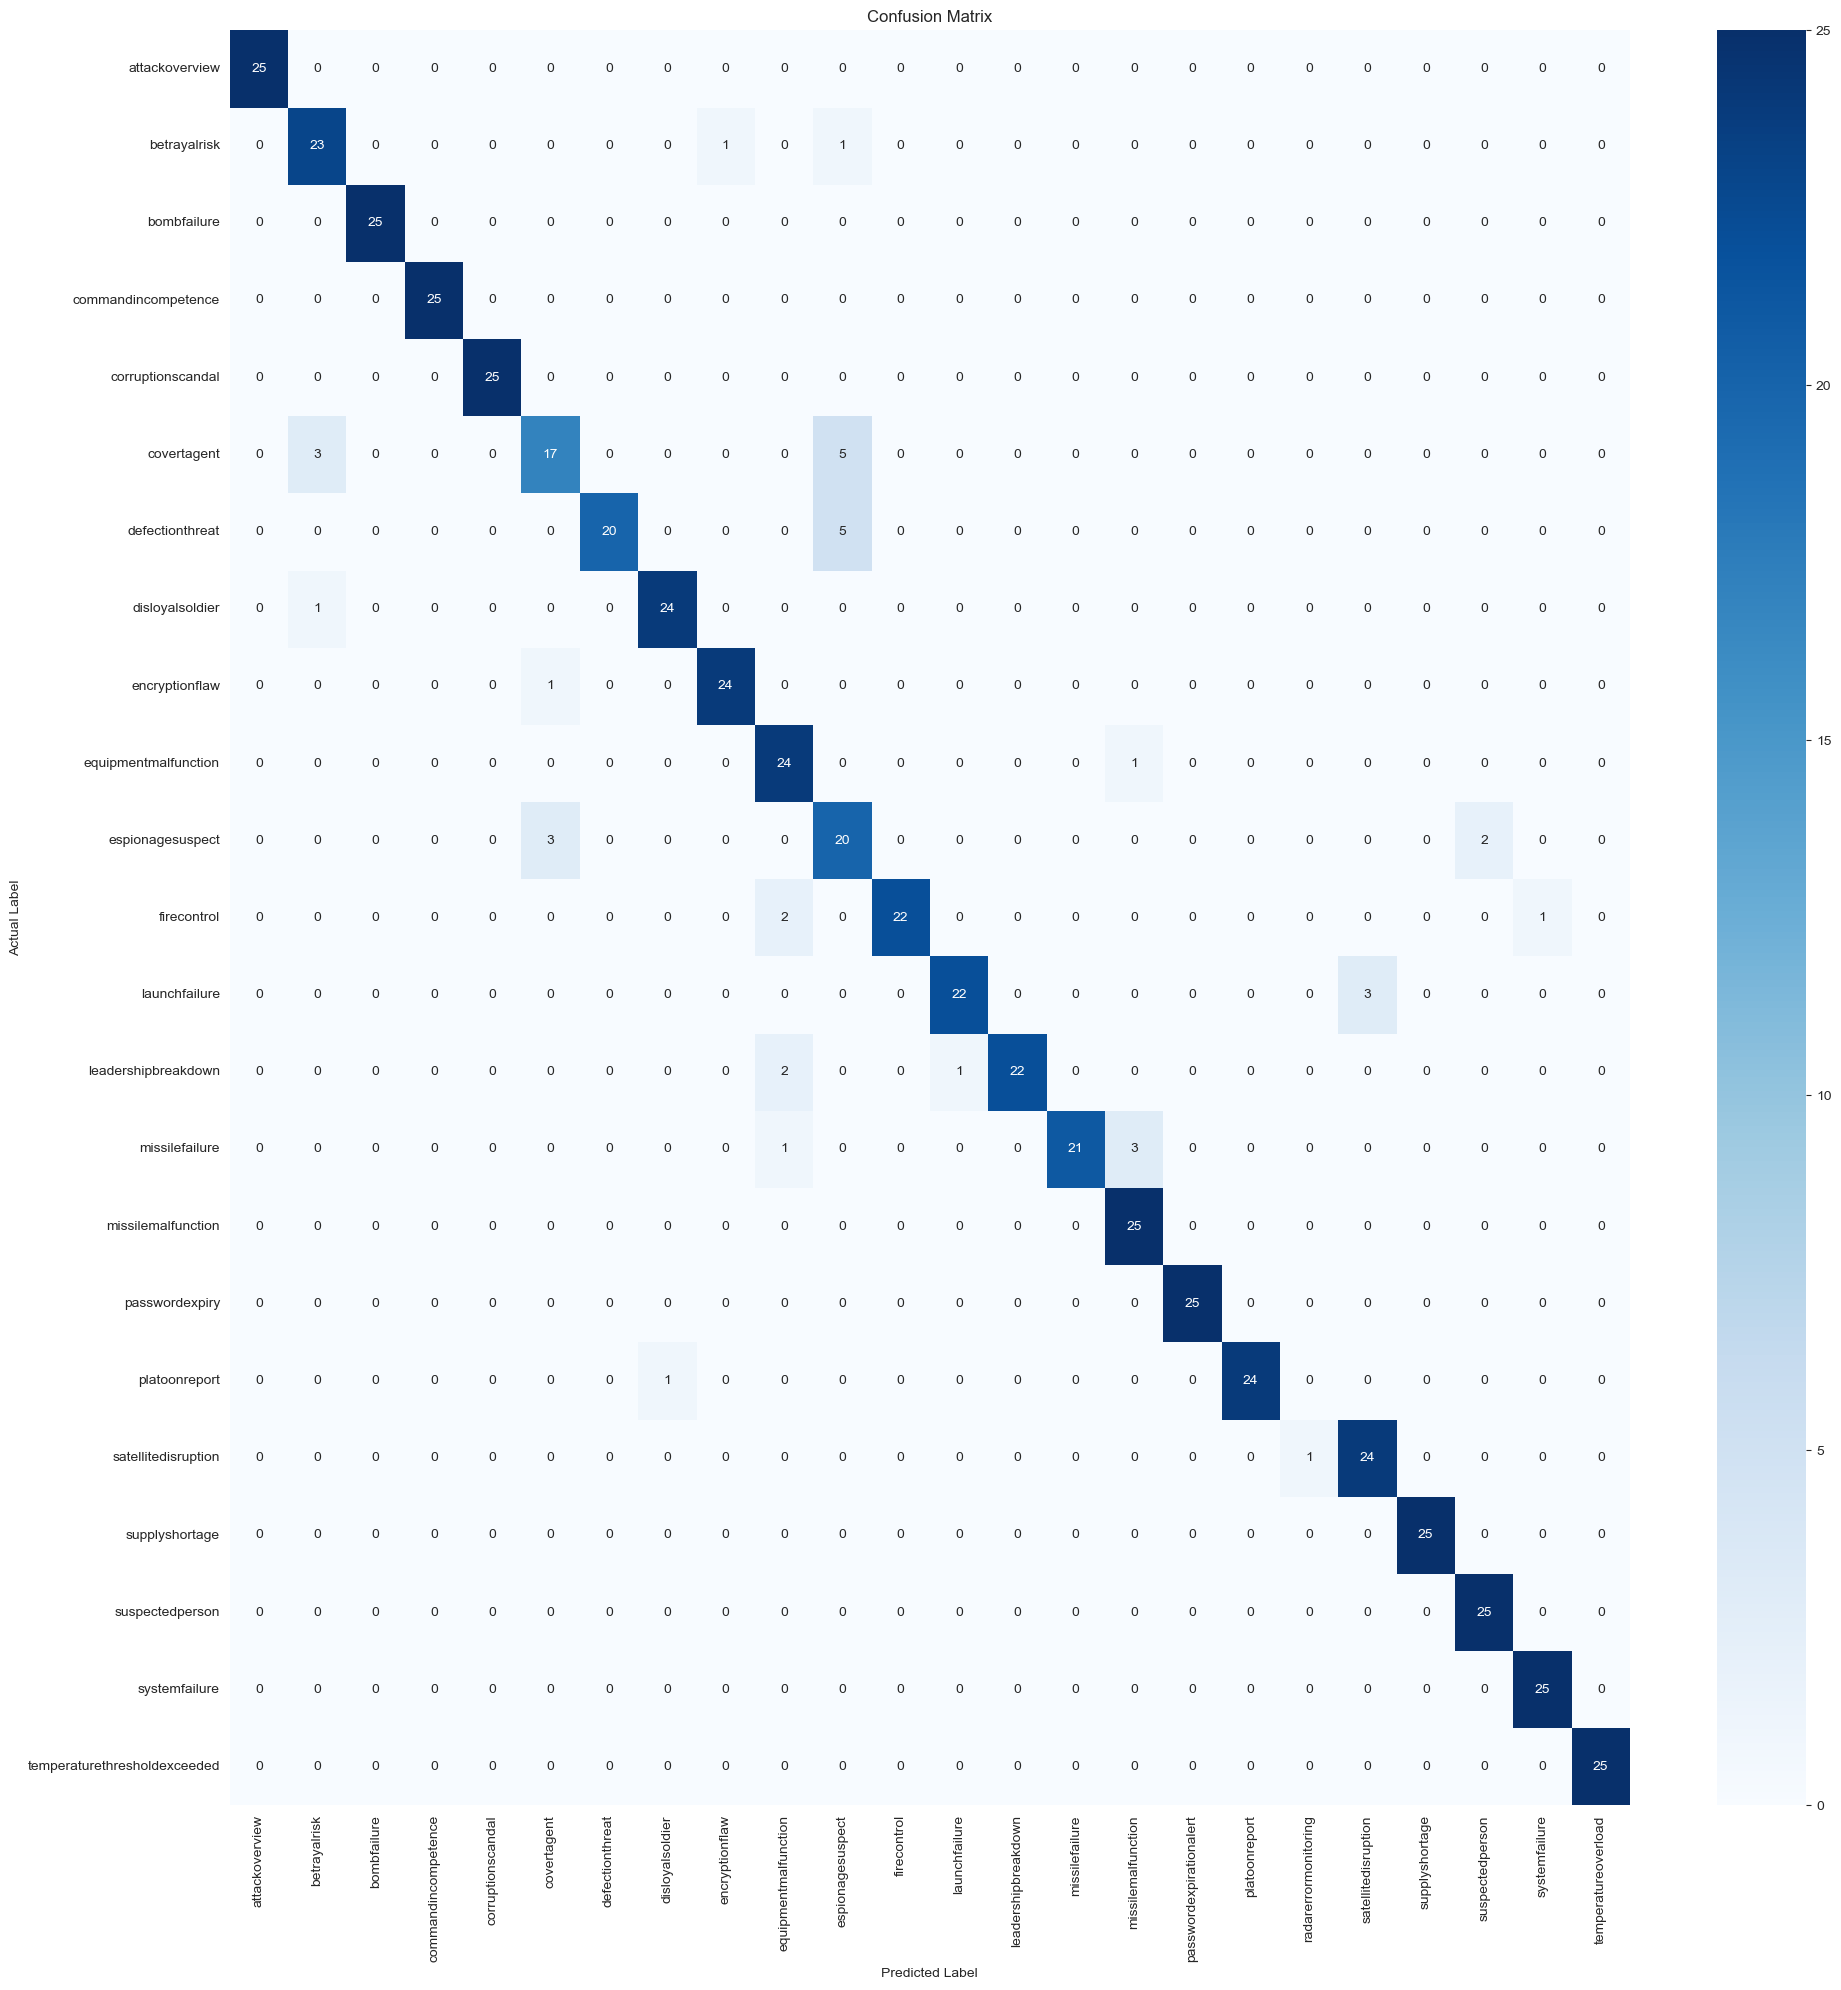

In [14]:

confusion_matrix = pd.crosstab(
    results_df["actual"],
    results_df["predicted"],
    # normalize='index'
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(
    confusion_matrix,
    annot=True,  # Show numbers in each cell
    cmap='Blues',  # Color scheme
    fmt='g',  # Format for the annotations
    xticklabels=confusion_matrix.columns
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()